# Load JSON File

In [1]:
# General imports
import os, json, cmath, math, sys, traceback, copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
from matplotlib.ticker import FormatStrFormatter

# Need use to raw string otherwise backslashes in Windows path accidentally cause problems since interpreter may confuse
# them for escape characters
fdir = r"C:\algos\jupyter-notebooks\data\2022-02-15_EuS"
jname = "After Probe Lift Info.json"
jpath = os.path.join(fdir, jname)

# Load JSON
jref = open(jpath)
measurements = json.load(jref)
jref.close()

# Unpack filenames
file_list = list(filter(lambda x: x != 'general_info', [*measurements]))

# Print out everything in general_info
print('General Info')
print('Description: {0} \n'.format(measurements['general_info']['description']))

for key in filter(lambda x: x != 'description', [*measurements['general_info']]):
    print('{0}: {1} \n'.format(key, measurements['general_info'][key]))

print('-----'*20 + '\n')
    
# List of keys to display
parameter_keys = ['fields', 'temps']

# Print out file names
for i, file in enumerate(file_list):
    print('{0}. {1} \n'.format(i, file))
    print('Description: {0}\n'.format(measurements[file]['description']))
    for key in parameter_keys:
        if key in measurements[file]:
            print(key + ': ' + ', '.join(map(str, measurements[file][key])) + '\n')
    print('-----'*20)


# Define helper functions here    

def colIndexGetter(cols_perscan, num_scans):
    """
        Partial application that returns a function that gets the index of a column from the complete data array
        given the column index within a scan, scan index, and parameter index.
    """
    return lambda col_index, s_index, p_index: p_index*cols_perscan*num_scans + s_index*cols_perscan + col_index

General Info
Description: After lifting probe sample resistance seems to have changed. Resistance of sample at 0 field at Vsd = 0V is about 1.2K Ohm as measured by potentiometer. Resistance of sample is about 1.5K Ohm when Vsd is above the SC gap. Temperature of probe is not accurate with actual sample temperature. 

Vsd_scaling: 0.000889 

dV_scaling: 0.001804 

----------------------------------------------------------------------------------------------------

0. 2022-02-15_FermiDiracFitvsdV.txt 

Description: dV vs temperatures obtained from fitting Fermi Dirac derivative to zero bias peak.

----------------------------------------------------------------------------------------------------
1. 2022-02-15_dIdV_-1.334mV - 1.334mV_201 steps_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_1.42K_0field_duringcooldown.txt 

Description: Taken during cooldown procedure when the probe temp reads approximately 1.42K. Hopefully during this time sample and probe temperature are roughly equal.

# Single File dIdV Waterfall Gradient Plot

Sample seems to have changed again after multiple condensations. Now the gap no longer seems to close near 2.75T. Instead the gap seems to grow wider as the field is increased.
Num Rows = 201
dV: 2.16e-05 
 Num Scans: 7 
 Num Cols: 4


<IPython.core.display.Javascript object>


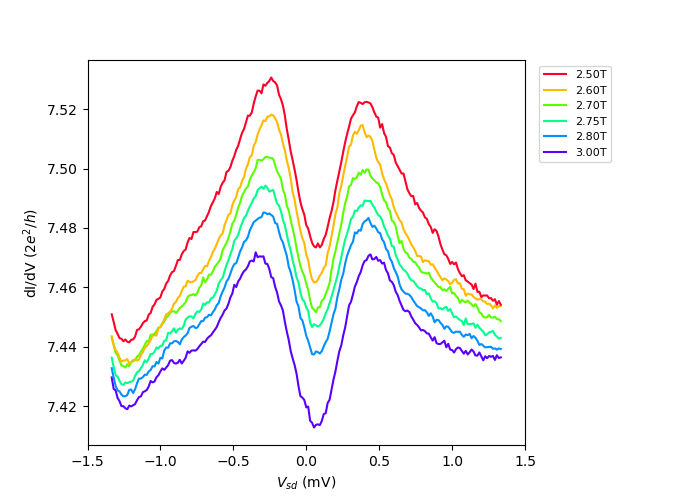

In [44]:
%matplotlib notebook

# Get file path of the corresponding file from the file_list
fname = file_list[8]
fpath = os.path.join(fdir, fname)
#fpath = os.path.join(r'C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact',
#                     '2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt')

# Load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
# Get dictionary of measurement information
measure_info = measurements[fname]
num_scans = measure_info['num_scans']
cols_perscan = measure_info['cols_perscan']
dV = measure_info['dV']
params = measure_info['fields']

# Print some info about the file
print(measure_info['description'])
print('Num Rows = {0}'.format(data.shape[0]))
print('dV: {0} \n Num Scans: {1} \n Num Cols: {2}'.format(dV, num_scans, cols_perscan))

# General settings for plotting data
legend_unit = 'T'
xscale = 1000 # Plot in units of mV
yscale =  1 / (dV * 7.7480917*10**-5)
offset = 0
plot_cols = (0, 1) # Pick which cols to plot as x and y
params_to_plot = [7, 8, 9, 10, 11, 12] # Indices of which params to plot

# Choose what to plot: 'average', 'all scans', 'first scan'
plot_type = 'average'

# Calculate average values of a scan if plotting average
avg_x = None
avg_y = None
getColIndex = colIndexGetter(cols_perscan, num_scans)
legend_labels = []

if plot_type == 'average':
    avg_x = list(map(
        lambda a: np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    avg_y = list(map(
        lambda a: np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))

# Build colormap so that full range of color map extends across the number of plots to be plotted
plot_cm = plt.cm.gist_rainbow(
    np.linspace(0, 1, len(params_to_plot) + 1 if plot_type != 'all scans' else num_scans*len(params_to_plot) + 1))

# Setup figure
plt.figure(figsize = (7,5))

# Plot the data and build legend
if plot_type == 'average':
    for c, i in enumerate(params_to_plot):
        plt.plot(avg_x[i]*xscale,
                 avg_y[i]*yscale + offset*c,
                 color = plot_cm[c], zorder = 100- 2*c)
        legend_labels.append('{:.2f}{:s}'.format(params[i], legend_unit))

elif plot_type == 'all scans':
    for c, i in enumerate(params_to_plot):
        for n in range(num_scans):
            plt.plot(data[:, getColIndex(plot_cols[0], n, i)]*xscale, 
                     data[:, getColIndex(plot_cols[1], n, i)]*yscale + offset*(c*num_scans + n), 
                     color = plot_cm[c*num_scans + n], zorder = 100 - c - n)
            legend_labels.append('{:.2f}{:s}, Scan {:d}'.format(params[i], legend_unit, n))
else:
    for c, i in enumerate(params_to_plot):
        plt.plot(data[:, getColIndex(plot_cols[0], 0, i)]*xscale,
                 data[:, getcolIndex(plot_cols[1], 0, i)]*yscale + offset*c, 
                 color = plot_cm[c], zorder = 100 - 5*c)
        legend_labels.append('{:.2f}{:s}'.format(params[i], legend_unit))

#plt.plot([-.02, -.02], [9.4, 8], linestyle = '--', color = 'black')

# Adjust ticks and axes limits and labels
#plt.yticks([0, .3])
#plt.yscale('log')
#plt.ylim([8, 9.4])
plt.ylabel(r'dI/dV ($2e^2/h$)')
#plt.ylabel('dI/dV Normalized')

plt.xticks(np.linspace(-1.5, 1.5, num = 7))
plt.xlim([-1.5, 1.5])
plt.xlabel(r'$V_{sd}$ (mV)')

# Adjust subplot position so labels fit inside
plt.gcf().subplots_adjust(right = 0.75)

# Show legend
plt.legend(legend_labels, ncol = 1, prop={'size': 8, 'stretch': 'semi-expanded'},
           bbox_to_anchor = (1.02, 1), loc = 'upper left')

# Show plot
plt.show()

# Save figure
plt.savefig('./plt_img/2022-02-15_EuS_samplechangedagain_2.5T-3T_rainbow.png', transparent = True, dpi = 200)

# Multiple File Average dIdV Waterfall Gradient Plot

<IPython.core.display.Javascript object>


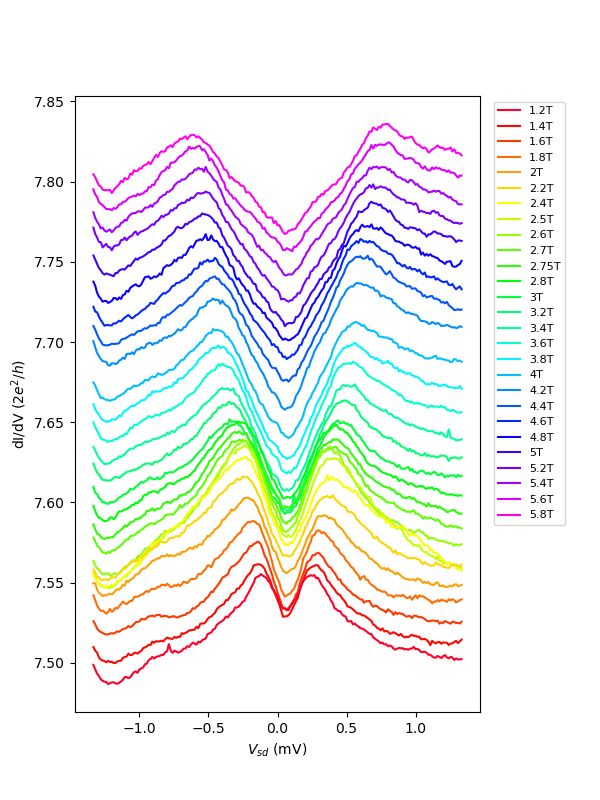

2022-02-15_dIdV_1.2T - 4T_240mK_largerdV_nogapclosing.txt 
 Num Data Sets: 126
 Num Scans: 7 
 Num Cols: 4 
 dV: 2.16e-05 

2022-02-15_dIdV_vary H persistent seq_4.2T - 7T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV.txt 
 Num Data Sets: 90
 Num Scans: 6 
 Num Cols: 4 
 dV: 2.16e-05 

['1.2T', '1.4T', '1.6T', '1.8T', '2T', '2.2T', '2.4T', '2.5T', '2.6T', '2.7T', '2.75T', '2.8T', '3T', '3.2T', '3.4T', '3.6T', '3.8T', '4T', '4.2T', '4.4T', '4.6T', '4.8T', '5T', '5.2T', '5.4T', '5.6T', '5.8T', '6T', '6.2T', '6.4T', '6.6T', '6.8T', '7T']


In [29]:
%matplotlib notebook

# Get list of files from file_list
plot_files = [8, 23]

# General parameters for plotting data
xscale = 1000 # plot in units of mV
offset = 0.015
plot_cols = (0, 1)
legend_unit = 'T'

# Setup figure
plt.figure(figsize = (6,8))

legend_labels = []
avg_xs = []
avg_ys = []

# Get data for each file
for i in plot_files:
    # Load data
    fname = file_list[i]
    fpath = os.path.join(fdir, fname)
    data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
    # Get measurement info
    measure_info = measurements[fname]
    num_scans = measure_info['num_scans']
    cols_perscan = 4 #measure_info['cols_perscan']
    dV = measure_info['dV']
    params = measure_info['fields']
    norm = 1 / (dV * 7.7480917*10**-5)
    
    # Print some info about the file
    print('{0} \n Num Data Sets: {1}'.format(fname, int(data.shape[1] / cols_perscan)))
    print(' Num Scans: {0} \n Num Cols: {1} \n dV: {2} \n'.format(num_scans, cols_perscan, dV))
    
    # Calculate average dIdV
    getColIndex = colIndexGetter(cols_perscan, num_scans)
    
    avg_xs.extend(map(
        lambda a: xscale*np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    avg_ys.extend(map(
        lambda a: norm*np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    ))
    
    # Add labels for the legend
    legend_labels.extend(['{0}{1}'.format(p, legend_unit) for p in params])
    

# Print list of parameters
print(legend_labels)

# Pick parameters to plot
params_to_plot = range(len(legend_labels) - 6)

# Build colormap
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, len(params_to_plot) + 1))

# Plot the data
for a, index in enumerate(params_to_plot):
    plt.plot(avg_xs[index], avg_ys[index] + offset*a, color = plot_cm[a], zorder = 100 - 2*a)

#for i, avg_x in enumerate(avg_xs):
#    plt.plot(avg_x*xscale, avg_ys[i]*norm + offset*i, color = plot_cm[i], zorder = 100- 2*i)

# Adjust ticks and axes limits and labels
#plt.yticks([0, .3])
#plt.yscale('log')
#plt.ylim([8, 9.4])
plt.ylabel(r'dI/dV ($2e^2/h$)')
#plt.ylabel('dI/dV Normalized')

#plt.xticks([-.5, -.25, 0, .25, .5])
#plt.xlim([-.5, .5])
plt.xlabel(r'$V_{sd}$ (mV)')

# Adjust subplot position so labels fit inside
plt.gcf().subplots_adjust(right = 0.8)

# Build legend
plt.legend(legend_labels, ncol = 1, prop={'size': 8, 'stretch': 'semi-expanded'},
           bbox_to_anchor = (1.02, 1), loc = 'upper left')

# Show plot
plt.show()

# Save figure
plt.savefig('./plt_img/2022-02-15_EuS_dIdV_1.2T - 5.8T_234mK_rawdata.png', transparent = True, dpi = 200)

# Single file Average dI/dV Heat / Intensity Map Plotting

Sample changed higher resistance. X offset corrected. File is combination of two files: 2022-02-15_dIdV_vary H seq_2.6T - 2.9T_-1.334mV - 1.334mV_201 steps_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK.txt and 2022-02-15_dIdV_vary H persis uniform_1.00T - 4.00T_-1.334mV - 1.334mV_201 steps_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK.txt
Num Rows = 201, Num Cols = 38
dV: 1.44e-05 
Num Scans: 1 
Num Cols: 2
Fields:
[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.6, 2.65, 2.7, 2.75, 2.8, 2.85, 2.9, 3, 3.25, 3.5, 3.75, 4]


<IPython.core.display.Javascript object>


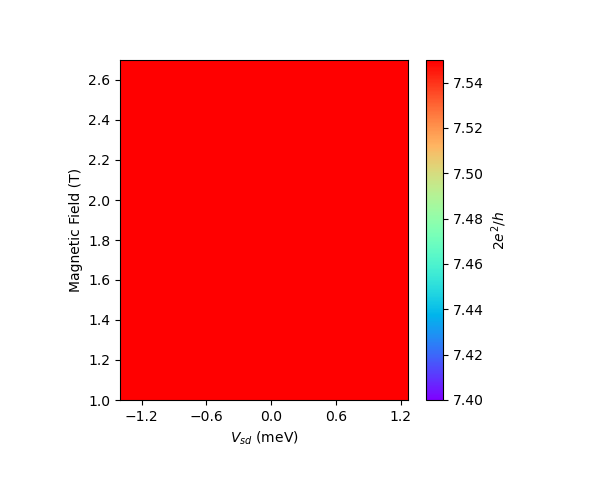

In [4]:
%matplotlib notebook

# Get file path of the corresponding file from the file_list
fname = file_list[28]
fpath = os.path.join(fdir, fname)
#fpath = os.path.join(r'C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact',
#                     '2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt')

# Load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)

# Get measurement info
measure_info = measurements[fname]
num_scans = measure_info['num_scans']
cols_perscan = measure_info['cols_perscan']
dV = measure_info['dV']
params = measure_info['fields']

print(measure_info['description'])
print('Num Rows = {0}, Num Cols = {1}'.format(data.shape[0], data.shape[1]))
print('dV: {0} \nNum Scans: {1} \nNum Cols: {2}'.format(dV, num_scans, cols_perscan))
print('Fields:')
print(params)

# General parameters for plotting data
xlimits = (-.0015, .0015) # Since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xscale = 1000 # plot in units of mV
zscale = 1 / (dV * 7.7480917*10**-5)
plot_cols = (0, 1) # Cols to use as x and z
p_int = (0, 10) # Pick an continuous interval of plots to use to form the heatmap
zmin = 7.4
zmax = 7.55

# Calculate averages
getColIndex = colIndexGetter(cols_perscan, num_scans)

avg_x = list(map(
    lambda a: np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
    range(p_int[0], p_int[1])
))

avg_z = list(map(
    lambda a: np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
    range(p_int[0], p_int[1])
))

# Form the mesh arrays for the heatmap
x = []
z = []

for i in range(len(avg_x)):
    x.append(avg_x[i][np.nonzero(np.logical_and(avg_x[i] >= xlimits[0], avg_x[i] <= xlimits[1]))])
    z.append(avg_z[i][np.nonzero(np.logical_and(avg_x[i] >= xlimits[0], avg_x[i] <= xlimits[1]))])
    
# Reshape arrays
for i in range(len(avg_x)):
    x[i] = np.reshape(x[i], (1, len(x[i])))
    z[i] = np.reshape(z[i], (1, len(z[i])))
    

z = zscale * np.concatenate(z, axis = 0)
x = xscale * np.concatenate(x, axis = 0)

# Repeat params array and then reshape to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(params[p_int[0]:p_int[1]], x.shape[1], axis = 0)
y = np.reshape(y, (p_int[1] - p_int[0], x.shape[1]))

# Plot data
fig, ax = plt.subplots(figsize = (6, 5))
pmesh = ax.pcolormesh(x, y, z, vmin = zmin, vmax = zmax, shading = 'gouraud', cmap = plt.get_cmap('rainbow'))

# Setup colorbar
cbar = plt.colorbar(pmesh, orientation = 'vertical')
cbar.set_label(r'$2e^2/h$')

# Adjust x,y axis ticks and labels        
ax.set_xlabel(r'$V_{sd}$ (meV)')
ax.set_ylabel('Magnetic Field (T)')
ax.set_xticks(np.linspace(-1.2, 1.2, num = 5))
#ax.set_xlim([-.5, .5])
#ax.set_yticks(np.linspace(0, 4, num = 17))

# Adjust plot so labels are visible
plt.subplots_adjust(left = 0.2 ,bottom = 0.2, right = 0.8)

plt.show()

#plt.savefig('./plt_img/2022-02-15_EuS_samplechangedagain_1.2T-4T.png', transparent = True)

# Multiple file average dIdV heat map plotting

<IPython.core.display.Javascript object>


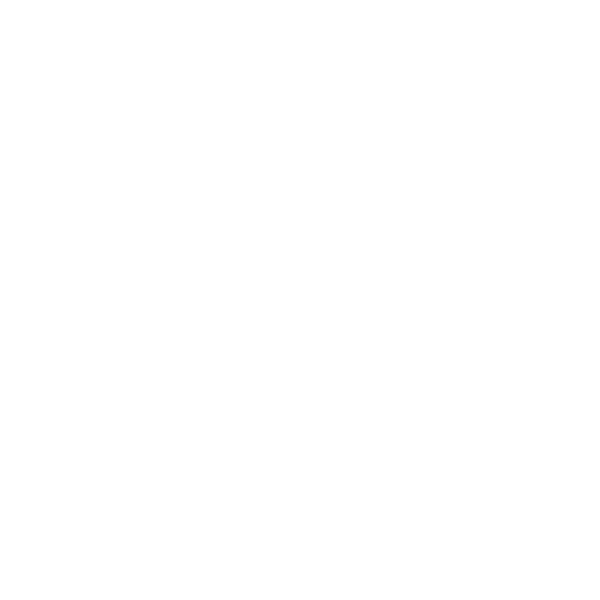

2022-02-15_dIdV_1.2T - 4T_240mK_largerdV_nogapclosing.txt 
 Num Data Sets: 126
 Num Scans: 7 
 Num Cols: 4 
 dV: 2.16e-05 

2022-02-15_dIdV_vary H persistent seq_4.2T - 7T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV.txt 
 Num Data Sets: 90
 Num Scans: 6 
 Num Cols: 4 
 dV: 2.16e-05 

Total num parameters: 33
[1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.5, 2.6, 2.7, 2.75, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4, 4.2, 4.4, 4.6, 4.8, 5, 5.2, 5.4, 5.6, 5.8, 6, 6.2, 6.4, 6.6, 6.8, 7]


<IPython.core.display.Javascript object>


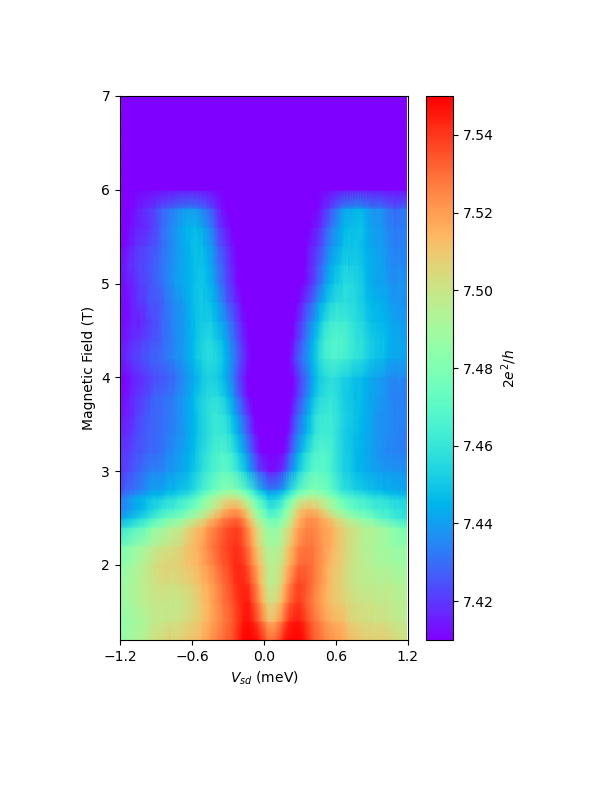

In [17]:
%matplotlib notebook

# Get list of files from file_list
plot_files = [8, 23]

# General parameters for plotting data
xlimits = (-.0012, .0012) # Since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xscale = 1000 # plot in units of mV
plot_cols = (0, 1) # Cols to use as x and z
zmin = 7.41
zmax = 7.55

# Setup figure
plt.figure(figsize = (6,6))

avg_xs = []
avg_zs = []
total_params = []

# Get data for each file
for i in plot_files:
    # Load data
    fname = file_list[i]
    fpath = os.path.join(fdir, fname)
    data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
    
    # Get measurement info
    measure_info = measurements[fname]
    num_scans = measure_info['num_scans']
    cols_perscan = measure_info['cols_perscan']
    dV = measure_info['dV']
    params = measure_info['fields']
    zscale = 1 / (dV * 7.7480917*10**-5)
    
    # Print some info about the file
    print('{0} \n Num Data Sets: {1}'.format(fname, int(data.shape[1] / cols_perscan)))
    print(' Num Scans: {0} \n Num Cols: {1} \n dV: {2} \n'.format(num_scans, cols_perscan, dV))
    
    # Calculate average dIdV
    getColIndex = colIndexGetter(cols_perscan, num_scans)
    
    avg_xs.extend(list(map(
        lambda a: xscale*np.sum([data[:, getColIndex(plot_cols[0], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    )))
    
    avg_zs.extend(list(map(
        lambda a: zscale*np.sum([data[:, getColIndex(plot_cols[1], i, a)] for i in range(num_scans)], axis = 0) / num_scans,
        range(len(params))
    )))
    
    # Extend complete list of params
    total_params.extend(params)


print('Total num parameters: {0}'.format(len(total_params)))
print(total_params)
p_int = (0, len(total_params)) # Pick an continuous interval of plots to use to form the heatmap

# Form the mesh arrays for the heatmap
x = []
z = []

for i in range(len(avg_xs)):
    x.append(avg_xs[i][np.nonzero(np.logical_and(avg_xs[i] >= xscale*xlimits[0], avg_xs[i] <= xscale*xlimits[1]))])
    z.append(avg_zs[i][np.nonzero(np.logical_and(avg_xs[i] >= xscale*xlimits[0], avg_xs[i] <= xscale*xlimits[1]))])
    
# Reshape arrays into 2D arrays for concatenation
for i in range(len(avg_xs)):
    x[i] = np.reshape(x[i], (1, len(x[i])))
    z[i] = np.reshape(z[i], (1, len(z[i])))

z = np.concatenate(z, axis = 0)
x = np.concatenate(x, axis = 0)

# Repeat params array and then reshape to get the Y-coord grid, similar to what one would get from meshgrid
y = np.repeat(total_params, x.shape[1], axis = 0)
y = np.reshape(y, (len(total_params), x.shape[1]))

# Plot data
fig, ax = plt.subplots(figsize = (6, 8))
pmesh = ax.pcolormesh(x[p_int[0]:p_int[1], :],
                      y[p_int[0]:p_int[1], :], 
                      z[p_int[0]:p_int[1], :],
                      vmin = zmin, vmax = zmax, shading = 'gouraud', cmap = plt.get_cmap('rainbow'))

# Setup colorbar
cbar = plt.colorbar(pmesh, orientation = 'vertical')
cbar.set_label(r'$2e^2/h$')

# Adjust x,y axis ticks and labels        
ax.set_xlabel(r'$V_{sd}$ (meV)')
ax.set_ylabel('Magnetic Field (T)')
ax.set_xticks(np.linspace(-1.2, 1.2, num = 5))
#ax.set_xlim([-.5, .5])
#ax.set_yticks(np.linspace(0, 4, num = 17))

# Adjust plot so labels are visible
plt.subplots_adjust(left = 0.2 ,bottom = 0.2, right = 0.8)

plt.show()

plt.savefig('./plt_img/2022-02-15_EuS_dIdV_1.2T-7T_240mK_heatmap.png', transparent = True, dpi = 200)

# Combine Files

In [3]:
# List of indices of files to combine
combine_files = [13, 21]

# List out parameters for each file
for index in combine_files:
    fname = file_list[index]
    print('\n{0}. {1}'.format(index, fname))
    print(measurements[fname]['fields'])


13. 2022-02-15_dIdV_vary H persistent seq_1.2T - 2.6T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV.txt
[1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.5, 2.6]

21. 2022-02-15_dIdV_vary H persistent seq_2.7T - 4T_-1.334mV - 1.334mV_5E-6 dIsens_8.89E-4 Vsdscale_sample1dev3changed_240mK_largerdV_2ndrun.txt
[2.7, 2.75, 2.8, 3, 3.2, 3.4, 3.6, 3.8, 4]


In [7]:
# Pick order of parameters to combine from each file
# Structure as a list of 2-element tuples: (file_index, parameter_index)

new_order = [(13, 0), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (13, 6), (13, 7), (13, 8), 
            (21, 0), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8)]

# Load data
file_mapper = dict(zip(combine_files, [i for i in range(len(combine_files))]))
data_list = []

for index in combine_files:
    fname = file_list[index]
    fpath = os.path.join(fdir, fname)
    data_list.append(np.genfromtxt(fpath, delimiter="\t", dtype=float))
    

# Combine data
plot_list = []    
for pair in new_order:
    
    file_index = pair[0]
    parameter_index = pair[1]
    
    # Get measurement info
    measure_info = measurements[file_list[file_index]]
    cols_perscan = measure_info['cols_perscan']
    num_scans = measure_info['num_scans']
    
    # Get data from data_list
    data = data_list[file_mapper[file_index]]
    
    # Append data at specific parameter to list
    start = cols_perscan*num_scans*parameter_index
    plot_list.append(data[:, start : start + cols_perscan*num_scans])
    

# Save file
np.savetxt(r'./data/2022-02-15_EuS/2022-02-15_dIdV_1.2T - 4T_240mK_largerdV_nogapclosing.txt',
           np.hstack(plot_list), fmt = '%.5e', delimiter = '\t')


In [ ]:
# Create a new dictionary to update JSON file

# Since we usually combine files with similar measurement settings, use an existing dict as a base
new_info = copy.deepcopy(measurements[file_list[combine_files[0]]])
new_info['fields'] = [measurements[file_list[p[0]]]['fields'][p[1]] for p in new_order]
new_info['description'] = 'Sample seems to have changed again after multiple condensations. Now the gap no longer seems to close near 2.75T. Instead the gap seems to grow wider as the field is increased.'

new_measurements = {}

with open(jpath, 'r') as jref: 
    new_measurements = json.load(jref)
    new_measurements[filename] = new_info

with open(jpath, 'w') as jref: # open in write mode this time
    json.dump(new_measurements, jref, indent = 4)

# Curve Fitting

Num data pts = 201, Num Plots = 10
Parameter sliced = 0.096


<IPython.core.display.Javascript object>


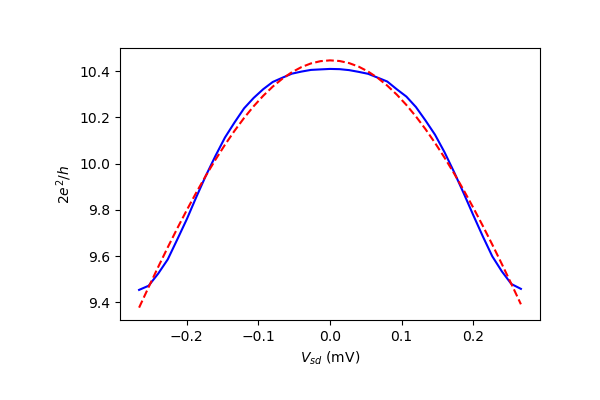

dV
0.00017316
Fitting parameters
[5.78645315e+00 2.71184766e-02 5.55319248e+01 2.97918040e+00]


In [53]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os
from matplotlib.ticker import FormatStrFormatter

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2022-02-15_EuS"
fname = "2022-02-15_dIdV_vary dV_5E-6 Iscale_8.89E-4 Vscale_sample1dev3changed_240mK_8mV-256mV.txt"
#fname = "2022-02-15_dIdV_vary dV_-1.334mV - 1.334mV_201 steps_5E-6 Iscale_8.89E-4 Vscale_1 scans_sample1dev3changed_240mK_cooled4hr_2nd sweep.txt"

fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
#data = data[:, 1:]
print('Num data pts = {0}, Num Plots = {1}'.format(data.shape[0], data.shape[1] // 2))

# Define constants
kb_meV = 8.617 * 10**-2 # Boltzmann constant in units of meV instead of eV

#since individual plots may be offset along x-axis from each other, find a common x-interval to use for heat map
xlimits = (-.001, .001)
xscale = 1000 #to multiply the x-coordinates
yscale = 1 #to multiply the y-coordinates
dV = 0.0023125*.78*10**-3*96
quantum_norm = True
single_x = False

params = [0.008, 0.016, 0.024, 0.032, 0.048, 0.064, 0.096, 0.128, 0.192, 0.256]

num_plots = data.shape[1] // 2
x = []
z = []

if not single_x:
    for i in range(num_plots):
        z.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2+1])
        x.append(data[np.nonzero(np.logical_and(data[:,i*2] >= xlimits[0], data[:,i*2] <= xlimits[1])), i*2])
    
    z = np.concatenate(z)
    x = xscale * np.concatenate(x)
else:
    for i in range(data.shape[1] - 1):
        z.append(data[:, i + 1])
        x.append(data[:, 0])
    
    z = np.vstack(z)
    x = xscale * np.vstack(x)

#normalize data
if quantum_norm:
    z = z / (dV * 7.7480917*10**-5)
else:
    for i in range(num_plots):
        z[i, :] *= 1 / np.average(data[0:5, i*2 + 1 if not single_x else i + 1])


# Curve fitting starts here

# Multiple Gaussian fit. Provide parameters as one long list in the order:
# [offset, gaussian1 center, gaussian1 amplitude, gaussian1 stdev, gaussian2 center, gaussian2 amplitude, ...]
def multiple_gaussian(x, *params):
    y = np.zeros_like(x)
    for i in range(1, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y + params[0]

# Derivative of Fermi-Dirac distribution fit. Provide paramters as list: [offset, offset slope, amplitude, temperature]
def fermi_derivative(x, *params):
    return params[0] + params[1]*x + (1/params[3])*params[2]*np.exp(x / (kb_meV * params[3])) / np.square(np.exp(x / (kb_meV * params[3])) + 1)

# Pick a curve to fit to
slice_index = 6
x_window = [54, 95]
print('Parameter sliced = {}'.format(params[slice_index]))

parameter_guess = [9, 0, 5, 2]
        
fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(x[slice_index, x_window[0] : x_window[1]], z[slice_index, x_window[0] : x_window[1]], color = 'blue')

curve_fit, pcov = optimize.curve_fit(fermi_derivative, x[slice_index, x_window[0] : x_window[1]], 
                              z[slice_index, x_window[0] : x_window[1]], parameter_guess)

print('dV')
print(dV)
print('Fitting parameters')
print(curve_fit)

fitted_y = fermi_derivative(x[slice_index, x_window[0] : x_window[1]], *curve_fit)
ax.plot(x[slice_index, x_window[0] : x_window[1]], fitted_y, color = 'red', linestyle = '--')

ax.set_ylabel(r'$2e^2/h$')
ax.set_xlabel(r'$V_{sd}$ (mV)')

#ax.set_xticks([-.1, -.05, 0, .05, .1])


plt.subplots_adjust(left = 0.2 ,bottom = 0.2)    
plt.show()

plt.savefig('./plt_img/2022-02-15_dIdV_96mVdV_FDfit.png', transparent = True)

# Scatter Plot

<IPython.core.display.Javascript object>


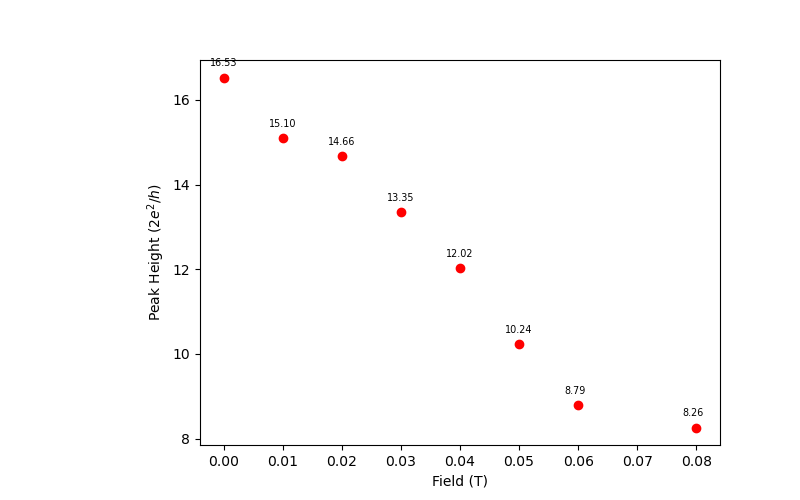

In [63]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os

#single file path
fdir = r"C:\algos\jupyter-notebooks\data\2022-02-15_EuS"
fname = "2022-02-15_FermiDiracFitvsdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

data = np.genfromtxt(fpath, delimiter="\t", dtype=float, skip_header = 1)

fig, ax = plt.subplots(figsize = (8,5))
#ax.tick_params(axis = 'both', which = 'both', bottom = False, left = True, labelleft = True, labelbottom = False)


fields = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08])
#pos = np.array([0.483, .4, .4, .346, .32, .266, .226, .193])
pos = np.array([16.528621851207284,
15.096817681930348,
14.663736132888337,
13.350599176138642,
12.021149959056656,
10.242575816012433,
8.79154648277244,
8.26100365963517])

data = np.vstack((fields, pos)).T

ax.scatter(data[:, 0], data[:, 1], c = 'red')

#ax.set_xticks(np.linspace(-.05, .05, num = 5))
#ax.set_xlim([-.05, .05])
ax.set_xlabel(r'Field (T)')

def applyToActual(x):
    return x*0.0023125*.78*1000

def actualToApply(x):
    return x / (0.0023125*.78*1000)

ax.set_ylabel(r'Peak Height ($2e^2/h$)')

#secax = ax.secondary_xaxis(location = 'top', functions = (actualToApply, applyToActual))
#secax.set_xlabel('Lock-in Applied dV (mV)')

for i, val in enumerate(data[:, 1]):
    ax.annotate(r'{:.2f}'.format(data[i, 1]), (data[i, 0], data[i, 1]), xytext = (-10, 8), textcoords = 'offset points',
               fontsize = 'x-small')

plt.subplots_adjust(left = 0.25) 
plt.show()

plt.savefig('./plt_img/2022-02-15_dIdV_zerobiaspeakheight_0T-0.08T.png', transparent = True)

# Multiple File Plotting

<IPython.core.display.Javascript object>


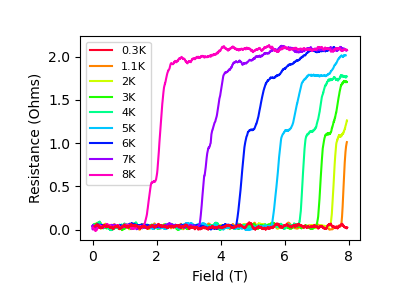

In [21]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, glob, os

#directory
data_dir = "C:/algos/jupyter-notebooks/data/2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact/Transport_inplane field"

#load data
data = []
os.chdir(data_dir)
files = glob.glob('*[0-9]K.txt')

for file in files:
    data.append(np.genfromtxt(file, delimiter="\t", dtype=float))

num_plots = len(data)


#build rainbow cmap for legend
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, num_plots))

fig, ax = plt.subplots(figsize=(4, 3))
plt.subplots_adjust(left = 0.2 ,bottom = 0.2)   

for i in range(num_plots):
    zorder = i
    if i is 0:
        zorder = 20
    ax.plot(data[i][:, 0], data[i][:, 1], color = plot_cm[i], zorder = zorder)

ax.set_xlabel('Field (T)')
ax.set_ylabel('Resistance (Ohms)')
ax.legend(['0.3K','1.1K', '2K', '3K', '4K', '5K', '6K', '7K', '8K'], prop={'size': 8})

plt.show()

#save img
os.chdir('C:/algos/jupyter-notebooks')
plt.savefig('./plt_img/2021-04-23_RvsH_12nm Nb_5nm Au_300mK-8K.png')

# dI/dV Multiple File Stacked and Shared Axis Plotting

Number of plots: 3
File0: 1.0 curves, 249 pts
File1: 1.0 curves, 1001 pts
File2: 1.0 curves, 395 pts
File3: 1.0 curves, 833 pts
File4: 1.0 curves, 1185 pts
File5: 1.0 curves, 201 pts


<IPython.core.display.Javascript object>


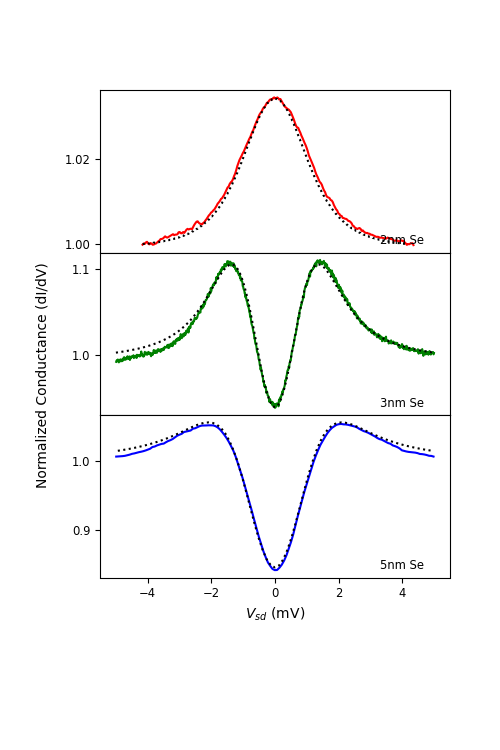

In [1]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import optimize, signal, interpolate
import cmath, math, os

quantum_cond = 7.7480917 * 10**-5
norm_len = 5
xscale = 1000
interval = (-.005, .005)


files = [
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-07-29_ptcontact_14nm Au_9nm Nb_2nm Se_raw.txt',
        'num': 0,
        'singlex': False,
        'color': 'red',
        'norm': 'avg',
        'norm_dir': 'end', 
        'label': '2nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-05-14_dIdV_pt contact_3nm Au - 9nm Nb_3nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'green',
        'norm': 'avg',
        'norm_dir': 'end', 
        'label': '3nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-06-26_dIdV_pt contact_27nm Au - 9nm Nb_5nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'blue',
        'norm': 'avg',
        'norm_dir': 'end', 
        'label': '5nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-07-29_ptcontact_14nm Au_9nm Nb_2nm Se_fittingonly.txt',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'ax': 0,
        'linestyle': ':'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-05-14_dIdV_pt contact_3nm Au - 9nm Nb_3nm Se_4.2K_0 field_fittingonly.dat',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'ax': 1,
        'linestyle': ':'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-06-26_dIdV_pt contact_27nm Au - 9nm Nb_5nm Se_4.2K_0 field_fittingonly.dat',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'ax': 2,
        'linestyle': ':'
    }
]

datas = []
num_plots = 0

for file in files:
    fpath = os.path.join(os.path.normpath(file['dir'].replace('\\', '/')), file['name'])
    datas.append(np.genfromtxt(fpath, delimiter="\t", dtype=float))
    if('ax' not in file):
        num_plots += 1

print('Number of plots: ' + str(num_plots))
        
for i, data in enumerate(datas):
    print('File{}: {} curves, {} pts'.format(i, data.shape[1] - 1 if files[i]['singlex'] else data.shape[1] / 2, data.shape[0]))

fig, ax = plt.subplots(nrows = num_plots, ncols = 1, figsize = (5, 2.5*num_plots), sharex = True)

plt.subplots_adjust(hspace = 0, bottom = 0.23, left = 0.2)

for i, data in enumerate(datas):
    plot_num = files[i]['num']
    singlex = files[i]['singlex']
    label = '' if 'label' not in files[i] else files[i]['label']
    color = files[i]['color']
    ax_num = i if 'ax' not in files[i] else files[i]['ax']
    linestyle = '-' if 'linestyle' not in files[i] else files[i]['linestyle']
    
    try:
        norm = float(files[i]['norm'])
    except ValueError:
        if 'norm_dir' in files[i] and files[i]['norm_dir'] is 'end':
            norm = 1 / np.average(data[-1*norm_len :, plot_num + 1] if singlex else data[-1*norm_len :, plot_num*2 + 1])
        else:
            norm = 1 / np.average(data[0:norm_len, plot_num + 1] if singlex else data[0:norm_len, plot_num*2 + 1])
   
    xdata = data[:, 0] if singlex else data[:, plot_num * 2]
    ydata = data[:, plot_num + 1] if singlex else data[:, plot_num * 2 + 1]
    mask = np.nonzero(np.logical_and(xdata >= interval[0], xdata <= interval[1]))
    
    ax[ax_num].plot(xscale * xdata[mask], norm * ydata[mask], color = color, linestyle = linestyle)
    ax[ax_num].tick_params(axis = 'both', labelsize = 'small')
    ax[ax_num].locator_params(axis = 'x', nbins = 6)
    ax[ax_num].locator_params(axis = 'y', nbins = 3)
    ax[ax_num].text(x = 0.8, y = .05, s = label, fontsize = 'small', transform = ax[ax_num].transAxes)

fig.text(0.07, 0.5, 'Normalized Conductance (dI/dV)', va='center', rotation='vertical')
plt.xlabel(r'$V_{sd}$ (mV)')

# additional adjustments to plt
#plt.ylabel(r'dI/dV $(2e^2/h)$')
#plt.xlim((-2, 2))

plt.show()

#plt.savefig('./plt_img/dIdV_ptcontact_barrier comparison_Se barrier with fits.png', dpi = 200, transparent = True)

# Single file dIdV grid of small plots

<IPython.core.display.Javascript object>


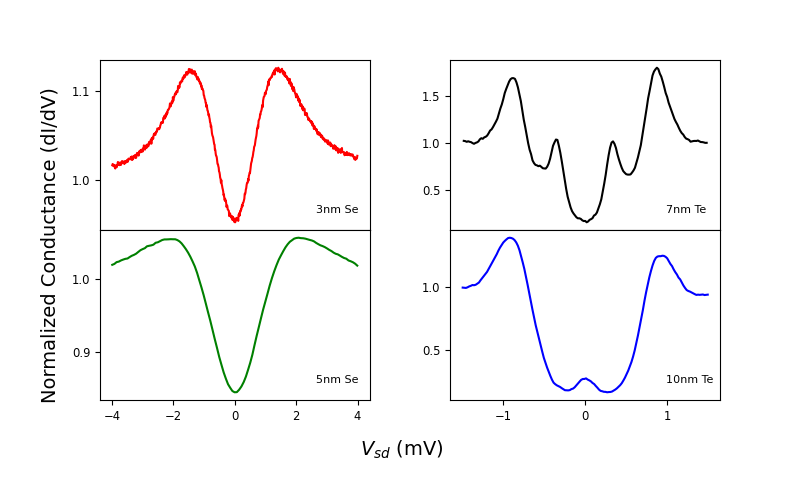

In [25]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy import optimize, signal, interpolate
import cmath, math, os

quantum_cond = 7.7480917 * 10**-5
plot_grid = (2, 2)
norm_len = 5
xscale = 1000
intervals = [(-.004, .004), (-.0015, .0015)]


files = [
    [{
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-05-14_dIdV_pt contact_3nm Au - 9nm Nb_3nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'red',
        'norm': 'avg',
        'label': '3nm Se'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\Dipstick Pt Contacts',
        'name': '2020-06-26_dIdV_pt contact_27nm Au - 9nm Nb_5nm Se_4.2K_0 field.dat',
        'num': 0,
        'singlex': False,
        'color': 'green',
        'norm': 'avg',
        'label': '5nm Se'
    }],
    # next column
    [{
        'dir': r'C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact',
        'name': '2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt',
        'num': 0,
        'singlex': False,
        'color': 'black',
        'norm': 'avg',
        'label': '7nm Te'
    },
    {
        'dir': r'C:\algos\jupyter-notebooks\data\2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact',
        'name': '2021-04-23_dIdV_vary H inplane persistent_-8T - 8T_0.25TdT_-1.7mV - 2.267mV_12nm Nb_5nmAu_300mK_smoothed_unnormalized_80uVdV.txt',
        'num': 33,
        'singlex': False,
        'color': 'blue',
        'norm': 'avg',
        'label': '10nm Te'
    }]
]

datas = []

for column in files:
    col = []
    for file in column:
        fpath = os.path.join(os.path.normpath(file['dir'].replace('\\', '/')), file['name'])
        col.append(np.genfromtxt(fpath, delimiter="\t", dtype=float))
    datas.append(col)

#for i, data in enumerate(datas):
#    print('File{}: {} plots, {} pts'.format(i, data.shape[1] - 1 if files[i]['singlex'] else data.shape[1] / 2, data.shape[0]))

fig, ax = plt.subplots(nrows = plot_grid[0], ncols = plot_grid[1],
                       figsize = (4*plot_grid[0], 2.5*plot_grid[1]), sharex = 'col')

# sharex = 'col' for column sharing

plt.subplots_adjust(bottom = 0.2)

for i, data_col in enumerate(datas):
    for j, data in enumerate(data_col):
        plot_num = files[i][j]['num']
        singlex = files[i][j]['singlex']
        label = files[i][j]['label']
        color = files[i][j]['color']
                       
        try:
            norm = float(files[i][j]['norm'])
        except ValueError:
            norm = 1 / np.average(data[0:norm_len, plot_num + 1] if singlex else data[0:norm_len, plot_num*2 + 1])

        xdata = data[:, 0] if singlex else data[:, plot_num * 2]
        ydata = data[:, plot_num + 1] if singlex else data[:, plot_num * 2 + 1]
        mask = np.nonzero(np.logical_and(xdata >= intervals[i][0], xdata <= intervals[i][1]))

        ax[j, i].plot(xscale * xdata[mask], norm * ydata[mask], color = color)
        ax[j, i].tick_params(axis = 'both', labelsize = 'small')
        ax[j, i].locator_params(axis = 'x', nbins = 6)
        ax[j, i].locator_params(axis = 'y', nbins = 3)
        ax[j, i].text(x = .8, y = .1, s = label, fontsize = 8, transform = ax[j, i].transAxes)

fig.text(0.05, 0.51, 'Normalized Conductance (dI/dV)', va='center', rotation='vertical', fontsize = 14)
fig.text(0.45, 0.1, r'$V_{sd}$ (mV)', va='center', rotation='horizontal', fontsize = 14)
#plt.xlabel(r'$V_{sd}$ (mV)')

plt.show()

plt.savefig('./plt_img/dIdV_ptcontact_barrier comparison.png', dpi = 200, transparent = True)

# Theory Curve Plotting

<IPython.core.display.Javascript object>


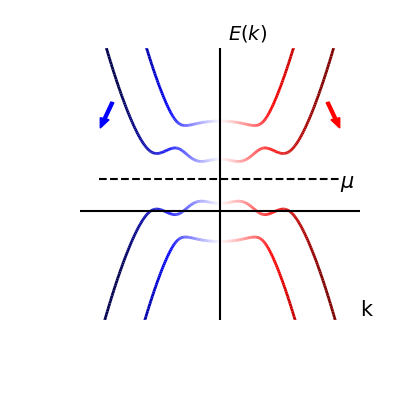

In [16]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from scipy import optimize, signal, interpolate
import cmath, math, os

t = 1
u = 1*t
b = 0.7
d = 1


def band(x, sign):
    return math.sqrt(b**2 + d**2 + (x**2 - u)**2 + (u*x)**2 + 
                     2*sign * math.sqrt(b**2*d**2 + b**2 * (x**2 - u)**2 + (u*x)**2*(x**2-u)**2))

'''
def band(x, sign):
    return x**2 - u + sign*math.sqrt(4*x**2 + b**2)
'''

xdata = np.linspace(-math.pi, math.pi, num = 301)
ydata = np.array([band(x, 1) for x in xdata])
ydata2 = np.array([band(x, -1) for x in xdata])
ydata3 = u - ydata
ydata4 = u - ydata2

ydata_pts = np.array([xdata, ydata +1.2]).T.reshape(-1, 1, 2)
ydata_segments = np.concatenate([ydata_pts[:-1], ydata_pts[1:]], axis = 1)

norm = plt.Normalize(-math.pi+.5, math.pi-.5)
lc= LineCollection(ydata_segments, cmap = 'seismic', norm = norm)
lc.set_array(xdata)
lc.set_linewidth(2)


ydata_pts2 = np.array([xdata, ydata2 +1.2]).T.reshape(-1, 1, 2)
ydata_segments2 = np.concatenate([ydata_pts2[:-1], ydata_pts2[1:]], axis = 1)

lc2= LineCollection(ydata_segments2, cmap = 'seismic', norm = norm)
lc2.set_array(xdata)
lc2.set_linewidth(2)

ydata_pts3 = np.array([xdata, ydata3]).T.reshape(-1, 1, 2)
ydata_segments3 = np.concatenate([ydata_pts3[:-1], ydata_pts3[1:]], axis = 1)

lc3= LineCollection(ydata_segments3, cmap = 'seismic', norm = norm)
lc3.set_array(xdata)
lc3.set_linewidth(2)


ydata_pts4 = np.array([xdata, ydata4]).T.reshape(-1, 1, 2)
ydata_segments4 = np.concatenate([ydata_pts4[:-1], ydata_pts4[1:]], axis = 1)

lc4= LineCollection(ydata_segments4, cmap = 'seismic', norm = norm)
lc4.set_array(xdata)
lc4.set_linewidth(2)


fig, ax = plt.subplots(figsize = (4,4))
plt.subplots_adjust(hspace = 0, bottom = 0.2, left = 0.2)

line1 = ax.add_collection(lc)
line2 = ax.add_collection(lc2)
line3 = ax.add_collection(lc3)
line4 = ax.add_collection(lc4)

ax.plot([-math.pi, math.pi], [1.2, 1.2],color = 'black',linestyle = '--')

#curve1 = ax.plot(xdata, ydata + 2.2, color = 'blue')
#curve2 = ax.plot(xdata, ydata2 + 2.2, color = 'red')
#curv2 = ax.plot([.25, .25], [0, 1.2], color = 'red', linestyle = '--')
#curv3 = ax.plot(xdata, ydata2, color = 'green')

#ax.scatter(m, alpha*m**2 + beta / 2 *m**4, color = 'red')
#ax.scatter(-m, alpha*m**2 + beta / 2 *m**4, color = 'red')

ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False, labelleft = False, labelbottom = False)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_xlabel(r'$E$', fontsize = 20, labelpad = 0)
#ax.xaxis.set_label_coords(1, -.05)
#ax.set_ylabel(r'$D_s(E)$', fontsize = 15, rotation = 0, labelpad = 25)
ax.set_ylim([-4, 6])
ax.set_xlim([-math.pi - .5, math.pi +.5])
#ax.set_xticks([-math.pi, 0, math.pi])
#ax.set_xticklabels([r'$\Delta$'], fontsize = 15)
#ax.set_yticks([0, .5, 1])
fig.text(0.57, .9,'$E(k)$', fontsize = 14)
fig.text(0.9, .21, 'k', fontsize = 15)

fig.text(0.85, .53, r'$\mu$', fontsize = 15)

plt.arrow(2.8, 4, .2, -.6, width = 0.08, color = 'red')

plt.arrow(-2.8, 4, -.2, -.6, width = 0.08, color = 'blue')

plt.show()

#plt.savefig('./plt_img/spinorbitbandszeemansc2.png', transparent = True, dpi = 200)

# Single Gap BTK Fitting

<IPython.core.display.Javascript object>


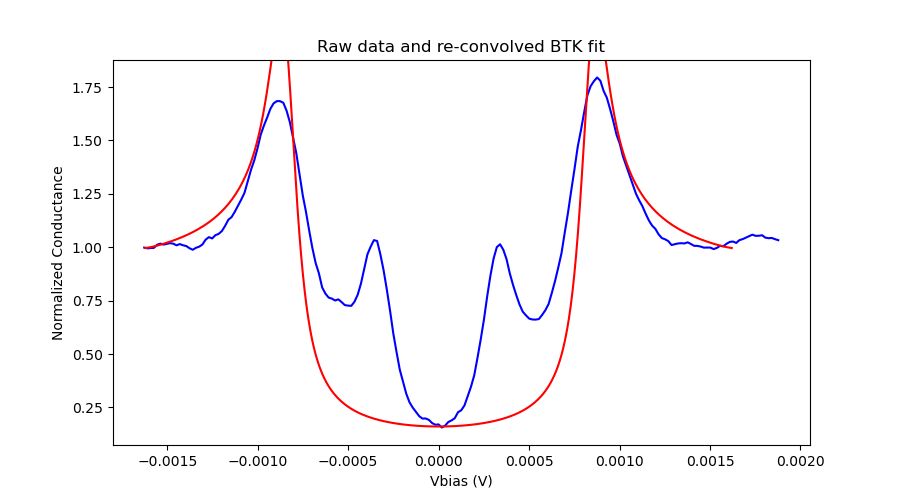

In [2]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math, os
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, BoundedFloatText
from ipywidgets import Button, RadioButtons, Text

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact"
fname = "2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
ydata = data[:,1] #select the y-data
xdata = data[:,0] #select the x-data
dlen = len(xdata)

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 4.2   #Temperature
norm_len = 5 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#check if xdata is not monotonic
for x in range(dlen - 1):
    if(xdata[x] > xdata[x + 1]):
        print(x)

#normalize conductance and determine data step size
ydata = normalize(ydata)

#bspline fitting for a smooth version of the data
#bspline will only be defined on the domain specified by the xdata, if the x values go out of bounds the function returns NaN
knots, coeff, order = interpolate.splrep(xdata, ydata, s = .04, k = 3)
spline = interpolate.BSpline(knots, coeff, order, extrapolate = False)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak and bspline based on uniform xdata
bspline_ydata = np.array(spline(uxdata))

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

#try fitting the convolved BTK conductance to the bspline ydata
popt, pcov = optimize.curve_fit(broad_conductance, uxdata, bspline_ydata, bounds = (lower_pbound, upper_pbound), method = 'trf')
g = popt[0]
d = popt[1]
z = popt[2]
fit_ydata = np.array([conductance(x, g, d, z) for x in uxdata])

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, thermal_broaden(fit_ydata, t), color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and re-convolved BTK fit')

# widget setup
out = Output()

width = {'width': '700px'}
temp = FloatText(value = .3, description = 'Temp')
gamma_param = FloatSlider(value=g, min=10**-6, max=10**-3, step=10**-6, description = r'$\Gamma$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
barrier = FloatSlider(value=z, min=0, max=5, step=0.01, description = r'$Z$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap = FloatSlider(value=d, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta$', 
                         continuous_update = False, layout = width, readout_format = '.2e')

save = Button(description = 'Save')

save_option = RadioButtons(options=('Fit', 'Raw'))

filetext = Text(value = 'C:/algos/jupyter-notebooks/data/',description = 'Filename', layout = width)


def update(temp, gamma_param, barrier, gap):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(conductance_arr(uxdata, gamma_param, gap, barrier), temp))
    fig.canvas.draw_idle()
    
def buttonClick(b):
    if(save_option.value is 'Fit'):
        np.savetxt(filetext.value, np.vstack((uxdata, np.array(fit_plt.get_ydata()))).T, delimiter = '\t', fmt = '%.4e')
    else:
         np.savetxt(filetext.value, np.vstack((xdata, ydata)).T, delimiter = '\t', fmt = '%.4e')
    
save.on_click(buttonClick)

it = interactive(update, temp = temp, gamma_param = gamma_param, barrier = barrier, gap = gap)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

hbox = HBox(children = (save, save_option))

vbox = VBox(children = (temp, gamma_param, barrier, gap, out, filetext, hbox), layout = box_layout)

display(vbox)

# Double BTK Fitting

<IPython.core.display.Javascript object>


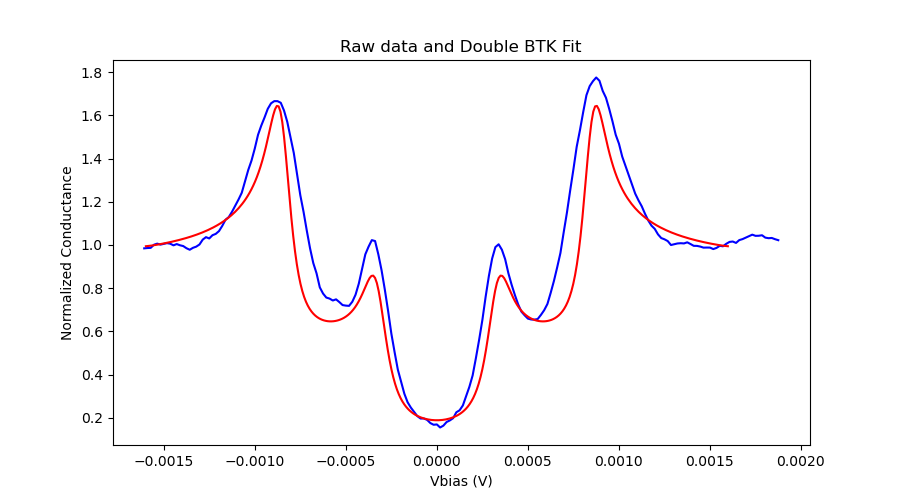

In [3]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math, os
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact"
fname = "2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float, skip_header = 1)
ydata = data[:,1] #select the y-data
xdata = data[:,0] #select the x-data
dlen = len(xdata)

# Scale/offset xdata
#xdata = xdata/1000
#xdata += .000084

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 1   #Temperature
norm_len = 10 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#normalize conductance and determine data step size
ydata = normalize(ydata)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

# Default fitting

initial = thermal_broaden(0.5 * conductance_arr(uxdata, .0001, .001, 1) + 0.5 * conductance_arr(uxdata, .0001, .0005, 1), 0.3)

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
origin, = ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, initial, color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and Double BTK Fit')

# widget setup
out = Output()

width = {'width': '700px'}
temp = FloatText(value = t, description = 'Temp')
gamma_param1 = FloatText(value = .0001, description = r'$\Gamma 1$')
barrier1 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap1 = FloatSlider(value=.001, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gamma_param2 = FloatText(value = .0001, description = r'$\Gamma 2$')
barrier2 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap2 = FloatSlider(value=.0005, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
weight = FloatSlider(value=0.5, min=0, max=1, step=.01, description = 'Weight', 
                         continuous_update = False, layout = width)

filetext = Text(value = 'C:/algos/jupyter-notebooks/data/',description = 'Filename', layout = width)

save = Button(description = 'Save')

save_option = RadioButtons(options=('Fit', 'Raw'))


def update(temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(weight*conductance_arr(uxdata, gamma_param1, gap1, barrier1) + (1-weight)*conductance_arr(uxdata, gamma_param2, gap2, barrier2), temp))
    fig.canvas.draw_idle()
    
def buttonClick(b):
    if(save_option.value is 'Fit'):
        np.savetxt(filetext.value, np.vstack((uxdata, np.array(fit_plt.get_ydata()))).T, delimiter = '\t', fmt = '%.4e')
    else:
         np.savetxt(filetext.value, np.vstack((xdata, ydata)).T, delimiter = '\t', fmt = '%.4e')
    
save.on_click(buttonClick)

it = interactive(update, temp = temp, gamma_param1 = gamma_param1, barrier1 = barrier1, gap1 = gap1,
                gamma_param2 = gamma_param2, barrier2 = barrier2, gap2 = gap2, weight = weight)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

hbox = HBox(children = (save, save_option))

vbox = VBox(children = (temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight, filetext, hbox), layout = box_layout)

display(vbox)

In [12]:
class myclass():
    def __init__(self, t):
        self.__t = t
        
class descendant(myclass):
    def __init__(self, t):
        myclass.__init__(self, t+1)
        self.__t = t
        
d = descendant(10)

print(d._myclass__t)
    

11
